# Práctica: Análisis de Costos de Seguros

En este proyecto, debe realizar operaciones de análisis en una base de datos de seguros que utilice los parámetros que se mencionan a continuación.

| Parameter |Description| Content type |
|---|----|---|
|age| Edad en años| integer |
|gender| Masculino o femenino|integer (1 or 2)|
| bmi | Indice de masa corporal | float |
|no_of_children| Número de hijos | integer|
|smoker| Fumador o no fumador | integer (0 or 1)|
|region| Región de USA - NW, NE, SW, S | integer (1,2,3 or 4 respectively)| 
|charges| Valor de cargos anuales en USD | float|

### Objetivos

En este proyecto, se verá:

 - Cargar los datos como un marco de datos 'pandas'
 - Limpiar los datos, cuidando las entradas en blanco
 - Ejecutar análisis exploratorios de datos (EDA) e identificar los atributos que más afectan a los cargos anuales de seguro (charges)
 - Desarrollar modelos de regresión lineal de una sola variable y multivariable para predecir los cargos anuales de seguro (charges)
 - Utilice la regresión de Ridge para refinar el rendimiento de los modelos de regresión lineal. 

### Preparación

Para ello se hará uso de las siguientes librerías.

- `pandas` para el manejo de datos.
- `numpy` para operaciones matemáticas.
- `sklearn` para machine learning y machine-learning-pipeline y funciones relacionadas.
- `seaborn` para visualización de datos.
- `matplotlib` para herramientas adiccionales de gráficos.

Impotar librerias.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

## 1. Importar el conjunto de datos

Descargamos el conjunto de datos en nuestro path actual.

In [2]:
import requests

url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'
filename = 'medical_insurance_dataset.csv'
response = requests.get(url)

with open(filename,'wb') as file:
    file.write(response.content)

In [3]:
df = pd.read_csv(filename)
df.head(10)

,19,1,27.9,0,1.1,3,16884.924
0,18,2,33.770,1,0,4,1725.55230
1,28,2,33.000,3,0,4,4449.46200
2,33,2,22.705,0,0,1,21984.47061
3,32,2,28.880,0,0,1,3866.85520
4,31,1,25.740,0,?,4,3756.62160
5,46,1,33.440,1,0,4,8240.58960
6,37,1,27.740,3,0,1,7281.50560
7,37,2,29.830,2,0,2,6406.41070
8,60,1,25.840,0,0,1,28923.13692
9,25,2,26.220,0,0,2,2721.32080


Añadir las cabezeras mencionadas anteriormente.

In [4]:
headers = ['age','gender','bmi','no_of_children','smoker','region','charges']

In [5]:
df.columns = headers
df.head()

,age,gender,bmi,no_of_children,smoker,region,charges
0,18,2,33.770,1,0,4,1725.55230
1,28,2,33.000,3,0,4,4449.46200
2,33,2,22.705,0,0,1,21984.47061
3,32,2,28.880,0,0,1,3866.85520
4,31,1,25.740,0,?,4,3756.62160


Comprobamos si exiten valores inexistentes en el dataframe.

In [6]:
'?' in df.values

True

Reemplazamos todos los valores '?' con datos NaN.

In [7]:
df.replace('?', np.NaN, inplace=True)

In [8]:
'?' in df.values

False

## 2. Manipulación de datos

Identificamos las columnas que contienen valores NaN o Null.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2767 non-null   object 
 1   gender          2771 non-null   int64  
 2   bmi             2771 non-null   float64
 3   no_of_children  2771 non-null   int64  
 4   smoker          2764 non-null   object 
 5   region          2771 non-null   int64  
 6   charges         2771 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB


In [10]:
missing_data = df.isnull()
for columns in missing_data.columns.values.tolist():
    print(missing_data[columns].value_counts(''))
    print('')

age
False    2767
True        4
Name: count, dtype: int64

gender
False    2771
Name: count, dtype: int64

bmi
False    2771
Name: count, dtype: int64

no_of_children
False    2771
Name: count, dtype: int64

smoker
False    2764
True        7
Name: count, dtype: int64

region
False    2771
Name: count, dtype: int64

charges
False    2771
Name: count, dtype: int64



La información nos muestra que existen datos faltantes en varias columnas, por ejemplo en la columna "age" existen 4 datos con valores NaN, en la columna "smoker", existen 7 valores con NaN.

Manejo de datos:

* Para atributos continuos, reemplazar los valores faltantes con el promedio de los valores.
* Para atributos categóricos reemplazar los valores faltantes con los valores mas frecuentes.
* Actualizar los tipos de datos en cada columna.
* Verificar los cambios realizados.

Organizamos.

- **Datos continuos:** age, bmi, no_of_children, charges.
- **Categóricos:** gender, smoker, region.

In [11]:
#Promedios para datos faltantes

avg_age = df['age'].astype(float).mean()
print('Promedio edad:',avg_age)

Promedio edad: 39.11709432598482


Reemplazamos los datos de promedios en los lugares vacios.

In [12]:
df['age'].replace(np.NaN, avg_age, inplace=True)

In [13]:
# Valor mas frecuente 

df['smoker'].value_counts()

smoker
0    2201
1     563
Name: count, dtype: int64

Reemplazamos el dato más frecuente.

In [14]:
df['smoker'].replace(np.NaN, 0, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2771 non-null   object 
 1   gender          2771 non-null   int64  
 2   bmi             2771 non-null   float64
 3   no_of_children  2771 non-null   int64  
 4   smoker          2771 non-null   object 
 5   region          2771 non-null   int64  
 6   charges         2771 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ KB


Ahora ya no existen datos faltantes en el dataframe.

Actualizamos los tipos de datos de las columnas, dado que "age" debería ser de tipo entero y se encuentra en tipo object, igual sucede con "smoker".

In [16]:
df[['age','smoker']] = df[['age','smoker']].astype(int) 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2771 non-null   int32  
 1   gender          2771 non-null   int64  
 2   bmi             2771 non-null   float64
 3   no_of_children  2771 non-null   int64  
 4   smoker          2771 non-null   int32  
 5   region          2771 non-null   int64  
 6   charges         2771 non-null   float64
dtypes: float64(2), int32(2), int64(3)
memory usage: 130.0 KB


También, prodriamos redondear los decimales de la columna "charges" a solo 2 decimales por ejemplo.

In [18]:
df[['charges']]= np.round(df[['charges']], 2)

In [19]:
df['charges'].head()

0     1725.55
1     4449.46
2    21984.47
3     3866.86
4     3756.62
Name: charges, dtype: float64

## 3. Analisis exploratorio de datos (EDA)

Vamos a buscar las variables que pueden ser candidatas para predecir los cargos anuales, para ello usaremos gráficas de regresión y valores de correlación.

Implementamos una grafica de regresión para **charges** con respecto a **bmi**.

(0.0, 66902.85800000001)

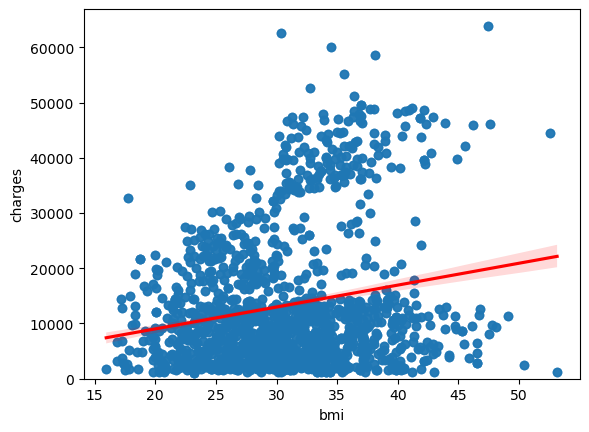

In [20]:
sns.regplot(x = 'bmi', y = 'charges', line_kws={'color':'r'}, data = df)
plt.ylim(0,)

Veamos la gráfica de regresion para "age" con respecto a "charges".

(0.0, 66902.85800000001)

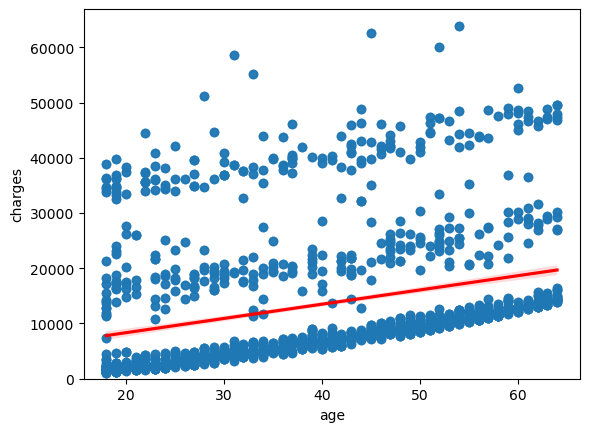

In [21]:
sns.regplot(x = 'age', y = 'charges', data = df, line_kws={'color':'r'})
plt.ylim(0,)

Ahora una gráfica boxplot para **smoker** con respecto a **charges**.

<Axes: xlabel='smoker', ylabel='charges'>

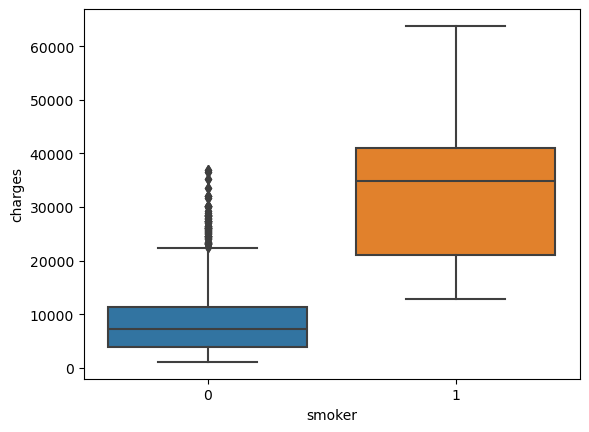

In [22]:
sns.boxplot(x = 'smoker', y = 'charges', data = df)

El gráfico nos muestra la variable "smoker" con respecto al precio, sus gráficas son lo suficientemente distintas como para considerar esta variable un buen predictor del precio.

Veamos las correlaciones de todas las variables del dataframe.

In [23]:
df.corr()

,age,gender,bmi,no_of_children,smoker,region,charges
age,1.000000,-0.026584,0.112859,0.037126,-0.022290,-0.006969,0.298892
gender,-0.026584,1.000000,0.042766,0.015693,0.083125,0.022360,0.062959
bmi,0.112859,0.042766,1.000000,-0.001642,0.011824,0.271200,0.199906
no_of_children,0.037126,0.015693,-0.001642,1.000000,0.007016,-0.025594,0.066551
smoker,-0.022290,0.083125,0.011824,0.007016,1.000000,0.053839,0.789141
region,-0.006969,0.022360,0.271200,-0.025594,0.053839,1.000000,0.054018
charges,0.298892,0.062959,0.199906,0.066551,0.789141,0.054018,1.000000


La tabla de correlación nos muestra que la variable **smoker** tiene la correlación más alta con una **fuerte correlación positiva**, esto indica que las personas que fuman tienden a tener cargos de seguro médico más altos y que sería una variable candidata altamente usable para modelos de predicción.

Por otra parte la variable **age** también podría ser una opción, la matriz muestra una correlación significativa (0.2988), lo que posiblemente indique que a mayor edad se puede tener cargos de seguro médico más altos.

De la misma manera, **bmi**, sugiere que las personas con un índice de masa corporal más alto pueden tener cargos de seguro más altos.

## 4. Desarrollo del modelo

Vamos a entrenar un modelo de `regresión lineal` para predecir el valor de **charges**, usando el atributo **smoker** del dataframe, y calculemos su valor de R-cuadrado. 

In [24]:
# Creamos el objeto LinearRegresion

lm = LinearRegression()

# Asignamos las variables
X = df[['smoker']] # variable independiente
Y = df['charges'] # variable dependiente

# Entrenamos al modelo
lm.fit(X,Y)

# Calculamos el valor de R-cuadrdo
print('El valor de R-cuadrado del modelo de regresion lineal es:', lm.score(X,Y))

El valor de R-cuadrado del modelo de regresion lineal es: 0.6227430402464125


El valor de R-cuadrado es 0.6222, lo que significa que aproximadamente el 62.22% de la variabilidad en los cargos de seguro es explicada por la variable "smoker". Aunque este valor indica un ajuste moderado del modelo, hay una cantidad significativa de variabilidad que no se está teniendo en cuenta.

Hagamos una `regresión lineal multiple` con todos los otros atributos del dataframe y veamos su valor de R-cuadrado.

In [25]:
# Creamos el objeto LinearRegresion
lm1 = LinearRegression()

# Asignamos las variables
Z = df[['age','gender','bmi','no_of_children','smoker','region']] # variable independiente
Y = df['charges'] # variable dependiente

# Entrenamos al modelo
lm1.fit(Z,Y)

# Calculamos el valor de R-cuadrdo
print('El valor de R-cuadrado del modelo de regresion lineal es:', lm1.score(Z,Y))

El valor de R-cuadrado del modelo de regresion lineal es: 0.7505888664568174


El valor de R-cuadrado es 0.7505, lo que indica que aproximadamente el 75.05% de la variabilidad en los cargos de seguro es explicada por todas estas variables juntas. Este valor es más alto que el del primer modelo, lo que sugiere que agregar más variables predictoras ha mejorado la capacidad del modelo para explicar la variabilidad en los datos.

Creemos un entrenamiento `pipeline` que use `StandardScaler()`, `PolynomialFeatures()` y `LinearRegression()` para crear un modelo que pueda predecir el valor de los cargos utilizando todos los demás atributos del conjunto de datos. Veamos si existe una mejora aún mayor en el rendimiento.

In [26]:
# Creamos el pipeline creando una lista de tuplas que incluyen el nombre del modelo o estimador y su constructor correspondiente
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model',LinearRegression())]

# Ingresamos al constructor
pipe = Pipeline(Input)

# Convertimos todos los datos a float para evitar errores de conversion
Z = Z.astype(float)

# Entrenamos el modelo
pipe.fit(Z, Y)

# Realizamos una prediccion 
ypipe = pipe.predict(Z)

# Calculamos el valor de R-cuadrado
print('El valor de R-cuadrado del modelo pipeline es:', r2_score(Y, ypipe))
print(ypipe[0:5])

El valor de R-cuadrado del modelo pipeline es: 0.8453700732446306
[2785.75 5214.75 4510.5  5161.   4803.25]


El modelo pipeline parece ser el más robusto de los que se ha probado hasta ahora, con el valor más alto de R-cuadrado. Esto indica que el modelo es capaz de capturar una mayor proporción de la variabilidad en los datos y, por lo tanto, puede proporcionar mejores predicciones de los cargos de seguro.

## 5. Refinamiento del modelo

Dividamos los datos en los subconjuntos entrenamiento y prueba, asumiendo un 20% de los datos reservados para pruebas.

In [27]:
# Aplicamos el refinamiento para Z e Y
x_train, x_test, y_train, y_test = train_test_split(Z, Y, test_size=0.2, random_state=1)
print("Numero de muestras del test :", x_test.shape[0])
print("Numero de muestas del entrenamiento:",x_train.shape[0])

Numero de muestras del test : 555
Numero de muestas del entrenamiento: 2216


Iniciamos una regresión de Ridgey asiganmos un hiperparametro alpha de 0.1. Entrenamos los modelos usando los datos de prueba del subconjunto y buscamos el valor de R-cuadrado.

In [28]:
# Creamos el objeto
RigeModel=Ridge(alpha=0.1)

# Entrenamos el objeto
RigeModel.fit(x_train, y_train)

# Prediccion
yhat = RigeModel.predict(x_test)
print('Prediccion:', yhat[0:4])
print('conjunto de pruebas :', y_test[0:4].values)

# R-cuadrado
print("El valor de R-cuadrado del modelo de Ridge es:",RigeModel.score(x_test, y_test))

# Tambien se puede usar
# print(r2_score(y_test,yhat))


Prediccion: [ 2812.72917963  2379.96091811  9906.19217065 27693.42325808]
conjunto de pruebas : [ 3484.33  3044.21 10096.97 18033.97]
El valor de R-cuadrado del modelo de Ridge es: 0.7254198858412231


Aplique la transformación polinómica a los parámetros de entrenamiento con degree=2. Utilice este conjunto de entidades transformadas para ajustar el mismo modelo de regresión, como el anterior, mediante el subconjunto de entrenamiento. Imprima el archivo  puntuación para el subconjunto de pruebas.

In [29]:
# Aplicamos la transformacion a polinomio de grado 2
pr=PolynomialFeatures(degree=2)

x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)

# Volvemos a aplicar al modelo de Ridge
RigeModel.fit(x_train_pr, y_train)

# Prediccion
yhat1 = RigeModel.predict(x_test_pr)
print('Prediccion:', yhat1[0:4])
print('conjunto de pruebas :', y_test[0:4].values)

# R-cuadrado
print("El valor de R-cuadrado es: ",r2_score(y_test,yhat1))



Prediccion: [ 5228.54764882  4092.97622122 10583.74267373 25920.56487674]
conjunto de pruebas : [ 3484.33  3044.21 10096.97 18033.97]
El valor de R-cuadrado es:  0.8208413195172477


Que sucedería si aumentamos el grado del polinomio, aumentando a grado 5, se observa que el valor de R-cuadrado disminuye, y para grados superirores este disminuirá aun más. Aunque grados 4, 5 y 6 siguen siendo buenos valores para R-cuadrado, no superán las espectativas de mejorara agrandes nivles de presición el modelo, mientras que de grado 6 para arriba ya no sirven.

In [30]:
# Aplicamos la transformacion a polinomio de grado 5
pr1=PolynomialFeatures(degree=5)

x_train_pr1 = pr1.fit_transform(x_train)
x_test_pr1 = pr1.fit_transform(x_test)

# Volvemos a aplicar al modelo de Ridge
RigeModel.fit(x_train_pr1, y_train)

# Prediccion
yhat2 = RigeModel.predict(x_test_pr1)
print('Prediccion:', yhat2[0:4])
print('conjunto de pruebas :', y_test[0:4].values)

# R-cuadrado
print("El valor de R-cuadrado es: ",r2_score(y_test,yhat2))

Prediccion: [ 5535.97278943  4257.5973275   9534.19910245 27185.11893583]
conjunto de pruebas : [ 3484.33  3044.21 10096.97 18033.97]
El valor de R-cuadrado es:  0.8174523580783555


D:\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.40815e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


La siguiente gráfica muestra lo sucedio.

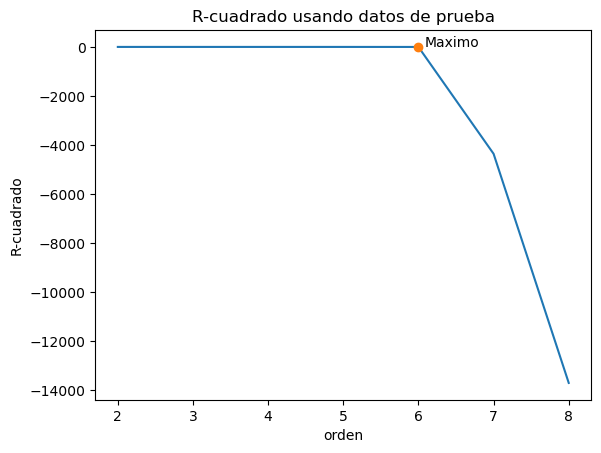

In [31]:
Rsqu_test = []

order = [2, 3, 4 , 5, 6, 7, 8]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr1 = pr.fit_transform(x_train)
    x_test_pr1 = pr.fit_transform(x_test)   
    lr = LinearRegression()
    lr.fit(x_train_pr1, y_train)
    Rsqu_test.append(lr.score(x_test_pr1, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('orden')
plt.ylabel('R-cuadrado')
plt.title('R-cuadrado usando datos de prueba')
plt.text(6.08, 0.85, 'Maximo')   
plt.plot(6, 0.716,marker ="o")

A partir del polinomio de grado 6 el valor de R-cuadrado decae drásticamente.

## Conclusión

Después de evaluar varios modelos de regresión en un conjunto de datos para predecir los cargos de seguro, aquí están cada uno de los valores:

1. Modelo de **regresión lineal simple** utilizando solo la variable "smoker":

**R-cuadrado:** 0.6222

Este modelo proporciona una estimación inicial de cómo la variable "smoker" está relacionada con los cargos de seguro. Sin embargo, su capacidad de predicción es moderada y limitada debido a la simplicidad del modelo.

2. Modelo de **regresión lineal múltiple** utilizando varias variables predictoras:

**R-cuadrado:** 0.7505

Al incluir múltiples variables predictoras, el modelo mejora en términos de capacidad de predicción en comparación con el modelo simple de una sola variable. Sin embargo, aún queda espacio para mejorar la capacidad predictiva.

3. Modelo de **regresión utilizando un pipeline** con escalado de características y expansión polinomial:

**R-cuadrado:** 0.8453

Este modelo, que incluye escalado de características y expansión polinomial, muestra un rendimiento mejorado en términos de R-cuadrado en comparación con los modelos anteriores. La capacidad de predicción ha mejorado significativamente gracias a la transformación de características y la inclusión de términos polinomiales.

4. Modelo de **regresión Ridge** sin transformación polinomial:
   
**R-cuadrado:** 0.7255

La inclusión de regularización Ridge en el modelo sin transformación polinomial ha mejorado ligeramente la capacidad de predicción en comparación con el modelo de regresión lineal simple. Sin embargo, el rendimiento aún no es tan bueno como el modelo con pipeline.

5. Modelo de **regresión Ridge con transformación polinomial de grado 2**:
   
**R-cuadrado:** 0.8206

La adición de transformación polinomial de grado 2 al modelo de regresión Ridge ha mejorado significativamente la capacidad de predicción en comparación con el modelo de regresión Ridge sin transformación polinomial. Sin embargo, todavía tiene un rendimiento ligeramente inferior al modelo con pipeline.

Aplicando las predicciones del mejor modelo que en este caso es de pipeline.

In [32]:
df['predictions_charges'] = ypipe
df.head(10)

,age,gender,bmi,no_of_children,smoker,region,charges,predictions_charges
0,18,2,33.770,1,0,4,1725.55,2785.75
1,28,2,33.000,3,0,4,4449.46,5214.75
2,33,2,22.705,0,0,1,21984.47,4510.50
3,32,2,28.880,0,0,1,3866.86,5161.00
4,31,1,25.740,0,0,4,3756.62,4803.25
5,46,1,33.440,1,0,4,8240.59,9553.50
6,37,1,27.740,3,0,1,7281.51,9790.75
7,37,2,29.830,2,0,2,6406.41,8151.75
8,60,1,25.840,0,0,1,28923.14,12919.00
9,25,2,26.220,0,0,2,2721.32,3807.75


El modelo de regresión utilizando un **pipeline con escalado de características y expansión polinomial** es el mejor en términos de capacidad de predicción, seguido por el modelo de regresión Ridge con transformación polinomial de grado 2

<hr/>

## Autor original:
Joseph Santarcangelo

## Traducción:
Jonathan Palan

## Carga y cambios

| Fecha             |Por         |  Descripción                                  |
| -----------------| ---------------| ----------------------------------------------|
| 2024-05-09     | Jonathan Palan | Traducción curso Data Analysis with Python|

## Bibliografía

[1] IBM,"Data Analysis with Python", available: https://www.coursera.org/learn/data-analysis-with-python, Skills Network
<hr/>